# f-scLVM

In this notebook we illustrate how f-scLVM can be used to identify biological processes driving variability between cells. 

First, we load some modules and set some directories; we here use data from 81 differentiating T-cells. 

In [1]:
import sys
import os
import scipy as SP

import fscLVM
from fscLVM import plotFactors, plotRelevance, saveFA, dumpFA
%pylab inline

#specify where the hdf5 file is
data_dir = '../data/'
out_dir = './results/'

Populating the interactive namespace from numpy and matplotlib


f-scLVM expects two input files, a gene expression file and an annotation file. The gene expression file is a text file containing the normalised, log-transformed gene expression matrix, with every row corresponding to a cell. Column names should be gene identifiers matching those in the annotation file. The annotation file is a text file with every row containing the name of a gene set, followed by the gene identifiers annotated to that gene set. We recommend using annotations such as those published in the REACTOME database or the Molecular signature database (MSigDB).
We provide a utility function, `load_txt`, for loading both text files. The loaded data can then be used to initialise the model with the `initFA` function.

In [65]:
#Annotation files
#Custom annotations for Th2 term and additional cell cycle term
annoFile =  os.path.join(data_dir,'gene_lists_fscLVM.txt') #custom
annoFileMSigDB = os.path.join(data_dir,'h.all.v5.0.symbols.gmt.txt') #MSigDB

#log transformed gene expression (cells x genes)
dataFile = os.path.join(data_dir,'Tcell.csv.zip')

#load data - here we have 2 annotation files, one containng MSigDB annotations, 
#the other containing custom gene sets; they can be passed to the load function as a list.
data = fscLVM.load_txt(dataFile, [annoFileMSigDB,annoFile],annoDBs=['MSigDB', 'custom'], 
                      niceTerms=[True,False], dataFile_delimiter=';')

I = data['I']
Y = data['Y']
terms = data['terms']
print(I.shape)
print(Y.shape)

#initialise model
FA = fscLVM.initFA(Y, terms,I,noise='gauss', nHidden=1, nHiddenSparse=0, 
                   pruneGenes=True, minGenes=15)
FA.terms

(7073, 52)
(81, 7073)


array(['hidden0', 'Myc targets v2', 'G2m checkpoint', 'Myc targets v1',
       'E2f targets', 'Oxidative phosphoryla', 'Unfolded protein resp',
       'Dna repair', 'Cell.cycle', 'Mtorc1 signaling', 'Spermatogenesis',
       'Tnfa signaling via nf', 'Th2', 'Glycolysis', 'Hypoxia',
       'P53 pathway', 'Heme metabolism', 'Fatty acid metabolism',
       'Complement', 'Interferon gamma resp', 'Epithelial mesenchyma',
       'Bile acid metabolism', 'Cholesterol homeostas',
       'Protein secretion', 'Adipogenesis', 'Mitotic spindle',
       'Estrogen response lat', 'Interferon alpha resp',
       'Xenobiotic metabolism', 'Uv response dn', 'Coagulation',
       'Il2 stat5 signaling', 'Kras signaling dn', 'Androgen response',
       'Tgf beta signaling', 'Il6 jak stat3 signali',
       'Inflammatory response', 'Uv response up', 'Kras signaling up',
       'Estrogen response ear', 'Peroxisome', 'Apoptosis',
       'Apical junction', 'Myogenesis', 'Reactive oxigen speci',
       'Allograft r

Next, we train the model and print diagnostics. 

In [4]:
#model training
FA.train()

#print diagnostics
FA.printDiagnostics()

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000
iteration 1100
iteration 1200
iteration 1300
iteration 1400
iteration 1500
iteration 1600
iteration 1700
iteration 1800
iteration 1900
Maximally  60.4166666667 % Genes per factor changed.


We next plot the relevance score of the individual terms. Since 2 of the main drivers of variability are cell cycle and Th2 differentiation, we also generate scatter plot, visualising the cell states of all cell with respect to these factors. Cells are coloured with the clusters identified in Buettner et al 2015. 

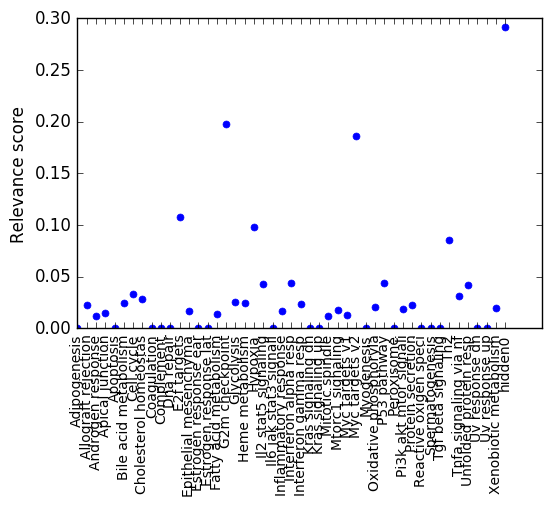

/Users/flo/projects/Auto_Bionf/scLVM2/fscLVM/utils.py:147: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if cols==None:


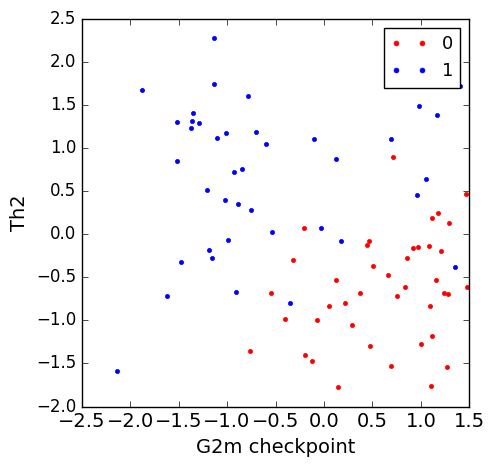

In [7]:
#FA.terms = SP.array(FA.terms)
#fig = plotRelevance(FA)
fscLVM.utils.plotTerms(FA=FA)

#get factors; analogous getters are implemented for relevance and weights (see docs)
plt_terms = ['G2m checkpoint','Th2']
X = FA.getX(terms=plt_terms)

#scatter plot of the top two factors
fig = plotFactors(X=-X, lab=data['lab'], terms=plt_terms, 
                  isCont=False, cols=SP.array(['red','blue']))


Next, we can regress out the cell cycle and hidden factors and visualise the residuals using a Bayesian GPLVM. This step requires the `GPy` package which can be installed via `pip`.

In [63]:
import GPy #
#Get model residuals
Ycorr = FA.regressOut(terms = ['hidden0', 'G2m checkpoint','Cell.cycle'])

## Model optimization
Ystd = Ycorr-Ycorr.mean(0)
input_dim = 2 # How many latent dimensions to use
kern = GPy.kern.RBF(input_dim) # RBF kernel
m = GPy.models.BayesianGPLVM(Ystd, input_dim=input_dim, kernel=kern, num_inducing=40)
m.optimize('scg', messages=1, max_iters=2000)




Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    00s00  0000   2.705608e+05           nan 
    00s14  0006   2.740329e+05   4.695792e+08 
    00s18  0008   2.726158e+05   4.695792e+08 
    03s21  0186   2.485400e+05   2.577498e+03 
    11s28  0664   2.483224e+05   6.532350e+03 
    35s49  1982   2.481501e+05   9.102176e+02 
 01m41s12  5624   2.481037e+05   1.403523e-01 
 01m42s13  5682   2.481037e+05   1.020603e-01 
 01m43s72  5774   2.481037e+05   8.299491e-02 
Runtime:  01m43s72
Optimization status: maxiter exceeded



Visualisation of the residuals. The colors correspond again to the clusters identified in Buettner et al 2015.

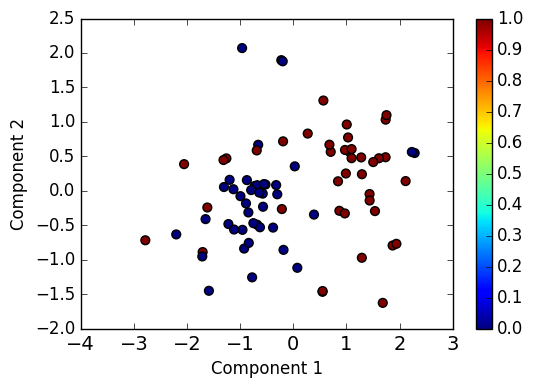

In [64]:
import pylab as PL
PL.scatter(m.X.mean[:,0], m.X.mean[:,1], 40, data['lab'])


PL.xlabel('Component 1')
PL.ylabel('Component 2')
PL.colorbar()